In [1]:
import numpy as np 
import pandas as pd
import pyfmi 
import random

random.seed(2023)

In [2]:
# excite signal: - generator for exciting signals
def excite(time, time_prev, csp_prev, hsp_prev, mode='cool'):
    csp = 22.
    hsp = 16.

    h = (time%86400)/3600
    h_prev = (time_prev%86400)/3600

    perturb = 0
    # only if time the begining of an hour
    if (h - int(h)) == 0.:
        # excite randomly
        if 9<=h<=17:
            perturb = random.randint(-3, 3) 

    # if the time is at the same hour, keep previous setpoints
    if int(h) == int(h_prev):
        csp = csp_prev 
        hsp = hsp_prev

    # mode during excitation
    if mode == "cool":
        csp += perturb
    elif mode == 'heat':
        hsp += perturb

    return csp, hsp

In [3]:
import collections 

model = pyfmi.load_fmu('model.fmu')
# print model interfaces
print(model.get_input_list())
print(model.get_output_list())


ts = (31+28+31+40+31)*24*3600.
te = ts + 60*24*3600.

options = model.simulate_options()
idf_steps_per_hour = 60
dt = 3600./idf_steps_per_hour
ncp = (te - ts)/dt
options['ncp'] = int(ncp)

# simulation setup
model.setup_experiment(start_time=ts, stop_time=te)
model.initialize()

# initialize output dic with empty list
res = collections.defaultdict(list)

# 
t = ts
t_prev = t - dt
csp_prev= 22.
hsp_prev= 16

while t < te:
    # excite setpoints 
    csp, hsp = excite(t, t_prev, csp_prev, hsp_prev, mode='cool')

    # proceed forward
    model.set('csp', csp)
    model.set('hsp', hsp)
    model.do_step(t, dt, new_step=True)
    res['t'].append(t)
    res['zone_temp'].append(model.get('zone_temp')[0])
    res['hvac_power'].append(model.get('hvac_power')[0])
    res['out_temp'].append(model.get('out_temp')[0])
    res['out_solar'].append(model.get('out_solar')[0])
    res['csp'].append(csp)
    res['hsp'].append(hsp)

    # sp memoery
    csp_prev = csp 
    hsp_prev = hsp
    # update clock
    t_prev = t
    t = t + dt

OrderedDict([('csp', <pyfmi.fmi.ScalarVariable2 object at 0x7f45699fec00>), ('hsp', <pyfmi.fmi.ScalarVariable2 object at 0x7f456997f470>)])
OrderedDict([('zone_temp', <pyfmi.fmi.ScalarVariable2 object at 0x7f449e57c3b0>), ('hvac_power', <pyfmi.fmi.ScalarVariable2 object at 0x7f456997ce50>), ('out_temp', <pyfmi.fmi.ScalarVariable2 object at 0x7f456997cb80>), ('out_solar', <pyfmi.fmi.ScalarVariable2 object at 0x7f456997e520>)])
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpv05cetpt//resources//model.idf starts with 22
Successfully finish reading weather file.
This is the Begin Month: 6
This is the Day of the Begin Month: 11
This is the End Month: 8
This is the Day of the End Month: 9
This is the New Day of Week: SUNDAY
Running EPMacro...
ExpandObjects Started.
 Begin reading Energy+.idd file.
 Done reading Energy+.idd file.
ExpandObjects Finished. Time:     0.031
EnergyPlus Starting
EnergyPlus, Version 22.2.0-c249759

In [4]:
pd.DataFrame(res).to_csv('data_excitation.csv')


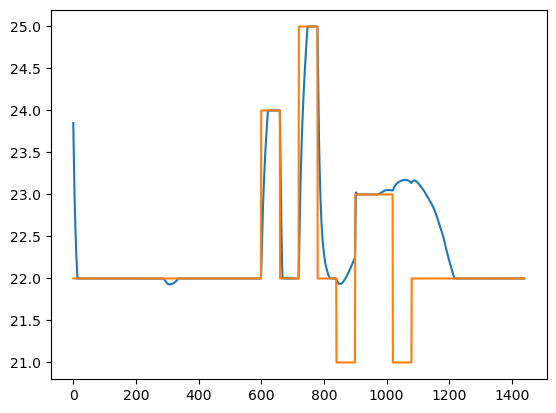

In [6]:
import matplotlib 
import matplotlib.pyplot as plt 
plt.figure()
plt.plot(res['zone_temp'][:60*24])
plt.plot(res['csp'][:60*24])
